# Insurance cost prediction using linear regression

In this assignment we're going to use information like a person's age, sex, BMI, no. of children and smoking habit to predict the price of yearly medical bills. This kind of model is useful for insurance companies to determine the yearly insurance premium for a person. The dataset for this problem is taken from: https://www.kaggle.com/mirichoi0218/insurance


We will create a model with the following steps:
1. Download and explore the dataset
2. Prepare the dataset for training
3. Create a linear regression model
4. Train the model to fit the data
5. Make predictions using the trained model


This assignment builds upon the concepts from the first 2 lectures. It will help to review these Jupyter notebooks:
- PyTorch basics: https://jovian.ml/aakashns/01-pytorch-basics
- Linear Regression: https://jovian.ml/aakashns/02-linear-regression
- Logistic Regression: https://jovian.ml/aakashns/03-logistic-regression
- Linear regression (minimal): https://jovian.ml/aakashns/housing-linear-minimal
- Logistic regression (minimal): https://jovian.ml/aakashns/mnist-logistic-minimal

As you go through this notebook, you will find a **???** in certain places. Your job is to replace the **???** with appropriate code or values, to ensure that the notebook runs properly end-to-end . In some cases, you'll be required to choose some hyperparameters (learning rate, batch size etc.). Try to experiment with the hypeparameters to get the lowest loss.


In [407]:
# Uncomment and run the commands below if imports fail
!conda install numpy pytorch torchvision cpuonly -c pytorch -y
!pip install matplotlib --upgrade --quiet
!pip install jovian --upgrade --quiet

Solving environment: done

# All requested packages already installed.

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [408]:
import torch
import jovian
import torchvision
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import DataLoader, TensorDataset, random_split
import numpy

In [409]:
project_name='02-insurance-linear-regression' # will be used by jovian.commit

## Step 1: Download and explore the data

Let us begin by downloading the data. We'll use the `download_url` function from PyTorch to get the data as a CSV (comma-separated values) file. 

In [410]:
DATASET_URL = "https://hub.jovian.ml/wp-content/uploads/2020/05/insurance.csv"
DATA_FILENAME = "insurance.csv"
download_url(DATASET_URL, '.')

Using downloaded and verified file: ./insurance.csv


To load the dataset into memory, we'll use the `read_csv` function from the `pandas` library. The data will be loaded as a Pandas dataframe. See this short tutorial to learn more: https://data36.com/pandas-tutorial-1-basics-reading-data-files-dataframes-data-selection/

# pd.read_csv('zoo.csv', delimiter = ',')
you can convert raw file into csv in this way

In [411]:
dataframe_raw = pd.read_csv(DATA_FILENAME)
dataframe_raw.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


We're going to do a slight customization of the data, so that you every participant receives a slightly different version of the dataset. Fill in your name below as a string (enter at least 5 characters)

In [412]:
your_name = "Coral" # at least 5 characters

The `customize_dataset` function will customize the dataset slightly using your name as a source of random numbers.

In [413]:
def customize_dataset(dataframe_raw, rand_str):
    dataframe = dataframe_raw.copy(deep=True)
    # drop some rows
    dataframe = dataframe.sample(int(0.95*len(dataframe)), random_state=int(ord(rand_str[0])))
    # scale input
    dataframe.bmi = dataframe.bmi * ord(rand_str[1])/100.
    # scale target
    dataframe.charges = dataframe.charges * ord(rand_str[2])/100.
    # drop column
    if ord(rand_str[3]) % 2 == 1:
        dataframe = dataframe.drop(['region'], axis=1)
    return dataframe

In [414]:
dataframe = customize_dataset(dataframe_raw, your_name)
dataframe.head()

,age,sex,bmi,children,smoker,charges
1054,27,female,23.83170,0,no,3822.956142
96,54,female,34.18800,3,no,13800.064800
1281,47,female,30.68595,2,yes,27970.696347
103,61,female,33.21120,3,yes,35274.098652
1252,20,male,30.30300,0,yes,18505.445580


Let us answer some basic questions about the dataset. 


**Q: How many rows does the dataset have?**

In [415]:
dataframe

,age,sex,bmi,children,smoker,charges
1054,27,female,23.83170,0,no,3822.956142
96,54,female,34.18800,3,no,13800.064800
1281,47,female,30.68595,2,yes,27970.696347
103,61,female,33.21120,3,yes,35274.098652
1252,20,male,30.30300,0,yes,18505.445580
...,...,...,...,...,...,...
668,62,male,35.53665,0,yes,52109.636949
23,34,female,35.43120,1,yes,42980.139552
410,19,male,19.40280,0,no,1848.327828
8,37,male,33.11130,2,no,7303.308198


In [416]:
num_rows = dataframe.shape[0]
print(num_rows)

1271


**Q: How many columns doe the dataset have**

In [417]:
num_cols = dataframe.shape[1]
print(num_cols)

6


# **** Here we define input_cols, output_cols, categorical_cols************

**Q: What are the column titles of the input variables?**

In [418]:
input_cols = list(dataframe.columns)[:-1]
input_cols

['age', 'sex', 'bmi', 'children', 'smoker']

**Q: Which of the input columns are non-numeric or categorial variables ?**

Hint: `sex` is one of them. List the columns that are not numbers.

In [419]:
categorical_cols = list(dataframe.select_dtypes('object'))
categorical_cols

['sex', 'smoker']

**Q: What are the column titles of output/target variable(s)?**

In [420]:
output_cols = list(dataframe.columns)[-1:]
output_cols

['charges']

**Q: (Optional) What is the minimum, maximum and average value of the `charges` column? Can you show the distribution of values in a graph?**
Use this data visualization cheatsheet for referece: https://jovian.ml/aakashns/dataviz-cheatsheet

min 1278.9362460000002
max 72698.2879314
avg 15176.124146456692


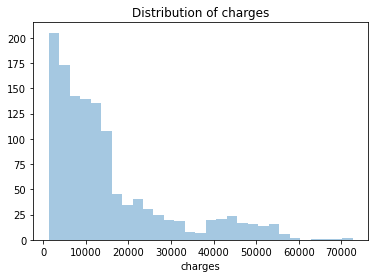

In [421]:
# Write your answer here
print('min', dataframe.charges.min())
print('max', dataframe.charges.max())
print('avg', dataframe.charges.mean())

import seaborn as sns
plt.title('Distribution of charges')
sns.distplot(dataframe.charges, kde = False)

Remember to commit your notebook to Jovian after every step, so that you don't lose your work.

In [422]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression


'https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression'

## Step 2: Prepare the dataset for training

We need to convert the data from the Pandas dataframe into a PyTorch tensors for training. To do this, the first step is to convert it numpy arrays.** If you've filled out `input_cols`, `categorial_cols` and `output_cols` correctly, this following function will perform the conversion to numpy arrays**.

 DataFrame.copy(self: ~FrameOrSeries, deep: bool = True) → ~FrameOrSeries[source]

    Make a copy of this object’s indices and data.

    When deep=True (default), a new object will be created with a copy of the calling object’s data and indices. Modifications to the data or indices of the copy will not be reflected in the original object (see notes below).

    When deep=False, a new object will be created without copying the calling object’s data or index (only references to the data and index are copied). Any changes to the data of the original will be reflected in the shallow copy (and vice versa).

In [423]:
dataframe

,age,sex,bmi,children,smoker,charges
1054,27,female,23.83170,0,no,3822.956142
96,54,female,34.18800,3,no,13800.064800
1281,47,female,30.68595,2,yes,27970.696347
103,61,female,33.21120,3,yes,35274.098652
1252,20,male,30.30300,0,yes,18505.445580
...,...,...,...,...,...,...
668,62,male,35.53665,0,yes,52109.636949
23,34,female,35.43120,1,yes,42980.139552
410,19,male,19.40280,0,no,1848.327828
8,37,male,33.11130,2,no,7303.308198


**To convert categorical_cols into tensor, You need to convert them into numbers first**

In [424]:
def dataframe_to_arrays(dataframe):
    # Make a copy of the original dataframe
    dataframe1 = dataframe.copy(deep=True)
    # Convert non-numeric categorical columns to numbers
    for col in categorical_cols: # categorical_cols == non_numeric_cols
        dataframe1[col] = dataframe1[col].astype('category').cat.codes # takes cols in alphabetical order
        # cat.codes is like converting your non-numeric col values into integer ( like one hot-coding???)
    # Extract input & outupts as numpy arrays
    inputs_array = dataframe1[input_cols].to_numpy()
    targets_array = dataframe1[output_cols].to_numpy()
    return inputs_array, targets_array

Read through the [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) to understand how we're converting categorical variables into numbers.

*testing*

In [425]:
dataframe[input_cols]

,age,sex,bmi,children,smoker
1054,27,female,23.83170,0,no
96,54,female,34.18800,3,no
1281,47,female,30.68595,2,yes
103,61,female,33.21120,3,yes
1252,20,male,30.30300,0,yes
...,...,...,...,...,...
668,62,male,35.53665,0,yes
23,34,female,35.43120,1,yes
410,19,male,19.40280,0,no
8,37,male,33.11130,2,no


*testing*

In [426]:
print(dataframe[output_cols])
print(dataframe[output_cols].to_numpy)

           charges
1054   3822.956142
96    13800.064800
1281  27970.696347
103   35274.098652
1252  18505.445580
...            ...
668   52109.636949
23    42980.139552
410    1848.327828
8      7303.308198
655   28120.857660

[1271 rows x 1 columns]
<bound method DataFrame.to_numpy of            charges
1054   3822.956142
96    13800.064800
1281  27970.696347
103   35274.098652
1252  18505.445580
...            ...
668   52109.636949
23    42980.139552
410    1848.327828
8      7303.308198
655   28120.857660

[1271 rows x 1 columns]>


testing

In [427]:
dataframe

,age,sex,bmi,children,smoker,charges
1054,27,female,23.83170,0,no,3822.956142
96,54,female,34.18800,3,no,13800.064800
1281,47,female,30.68595,2,yes,27970.696347
103,61,female,33.21120,3,yes,35274.098652
1252,20,male,30.30300,0,yes,18505.445580
...,...,...,...,...,...,...
668,62,male,35.53665,0,yes,52109.636949
23,34,female,35.43120,1,yes,42980.139552
410,19,male,19.40280,0,no,1848.327828
8,37,male,33.11130,2,no,7303.308198


In [428]:
inputs_array, targets_array = dataframe_to_arrays(dataframe) # convert input_cols, output_cols(targets) into array
inputs_array, targets_array

(array([[27.     ,  0.     , 23.8317 ,  0.     ,  0.     ],
        [54.     ,  0.     , 34.188  ,  3.     ,  0.     ],
        [47.     ,  0.     , 30.68595,  2.     ,  1.     ],
        ...,
        [19.     ,  1.     , 19.4028 ,  0.     ,  0.     ],
        [37.     ,  1.     , 33.1113 ,  2.     ,  0.     ],
        [52.     ,  0.     , 28.083  ,  2.     ,  1.     ]]),
 array([[ 3822.956142],
        [13800.0648  ],
        [27970.696347],
        ...,
        [ 1848.327828],
        [ 7303.308198],
        [28120.85766 ]]))

**Q: Convert the numpy arrays `inputs_array` and `targets_array` into PyTorch tensors. Make sure that the data type is `torch.float32`.**

In [429]:
inputs = torch.from_numpy(numpy.array(inputs_array, dtype = 'float32'))
targets = torch.from_numpy(numpy.array(targets_array, dtype = 'float32'))
inputs, targets

(tensor([[27.0000,  0.0000, 23.8317,  0.0000,  0.0000],
         [54.0000,  0.0000, 34.1880,  3.0000,  0.0000],
         [47.0000,  0.0000, 30.6859,  2.0000,  1.0000],
         ...,
         [19.0000,  1.0000, 19.4028,  0.0000,  0.0000],
         [37.0000,  1.0000, 33.1113,  2.0000,  0.0000],
         [52.0000,  0.0000, 28.0830,  2.0000,  1.0000]]),
 tensor([[ 3822.9561],
         [13800.0645],
         [27970.6973],
         ...,
         [ 1848.3279],
         [ 7303.3081],
         [28120.8574]]))

In [430]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

Next, we need to create PyTorch datasets & data loaders for training & validation. We'll start by creating a `TensorDataset`.

In [431]:
dataset = TensorDataset(inputs, targets)

**Q: Pick a number between `0.1` and `0.2` to determine the fraction of data that will be used for creating the validation set. Then use `random_split` to create training & validation datasets. **

In [432]:
val_percent = 0.2 # between 0.1 and 0.2
val_size = int(num_rows * val_percent)
train_size = num_rows - val_size


train_ds, val_ds = random_split(dataset, [val_size, train_size])
# split the dataset by using size
# Use the random_split function to split dataset into 2 parts of the desired length

Finally, we can create data loaders for training & validation.

**Q: Pick a batch size for the data loader.**

In [433]:
batch_size = 64

In [434]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
# need to shuffle the train_ds for better result
val_loader = DataLoader(val_ds, batch_size)

Let's look at a batch of data to verify everything is working fine so far.

In [435]:
for xb, yb in train_loader:
    print("inputs:", xb)
    print("targets:", yb)
    break

inputs: tensor([[19.0000,  1.0000, 38.7390,  0.0000,  1.0000],
        [32.0000,  0.0000, 33.0059,  0.0000,  0.0000],
        [42.0000,  0.0000, 27.7334,  2.0000,  0.0000],
        [19.0000,  1.0000, 21.9780,  0.0000,  0.0000],
        [53.0000,  1.0000, 32.0568,  0.0000,  0.0000],
        [61.0000,  1.0000, 35.8530,  2.0000,  0.0000],
        [45.0000,  0.0000, 28.5270,  3.0000,  0.0000],
        [27.0000,  0.0000, 34.8540,  0.0000,  1.0000],
        [19.0000,  0.0000, 30.9690,  0.0000,  1.0000],
        [47.0000,  1.0000, 40.1820,  1.0000,  0.0000],
        [26.0000,  0.0000, 44.6054,  0.0000,  0.0000],
        [30.0000,  0.0000, 36.9963,  1.0000,  0.0000],
        [36.0000,  0.0000, 28.7490,  1.0000,  0.0000],
        [46.0000,  1.0000, 30.6360,  0.0000,  0.0000],
        [19.0000,  0.0000, 36.7521,  0.0000,  1.0000],
        [55.0000,  1.0000, 23.8650,  1.0000,  0.0000],
        [41.0000,  0.0000, 35.1148,  1.0000,  0.0000],
        [37.0000,  0.0000, 52.8360,  2.0000,  1.0000],
  

Let's save our work by committing to Jovian.

In [436]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression


'https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression'

## Step 3: Create a Linear Regression Model

Our model itself is a fairly straightforward linear regression (we'll build more complex models in the next assignment). 


In [437]:
input_size = len(input_cols)
output_size = len(output_cols)

**Q: Complete the class definition below by filling out the constructor (`__init__`), `forward`, `training_step` and `validation_step` methods.**

Hint: Think carefully about picking a good loss fuction (it's not cross entropy). Maybe try 2-3 of them and see which one works best. See https://pytorch.org/docs/stable/nn.functional.html#loss-functions

Forward selections is a type of stepwise regression which begins with an empty model and adds in variables one by one. In each forward step, you add the one variable that gives the single best improvement to your model.

tensor.detach() creates a tensor that shares storage with tensor that does not require grad. It detaches the output from the computational graph. So no gradient will be backpropagated along this variable.

L1 Loss Function is used to minimize the error which is the sum of the all the absolute differences between the true value and the predicted value.
I tried with mse.  I got nan values. So I used L1.

In [438]:
class InsuranceModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size) # fill this (hint: use input_size & output_size defined above)
        
    def forward(self, xb):
        out = self.linear(xb)                          # fill this
        return out
    
    def training_step(self, batch):
        inputs, targets = batch 
        # Generate predictions
        out = self(inputs)          
        # Calcuate loss
        loss = F.smooth_l1_loss(out,targets)                      # fill this
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.smooth_l1_loss(out,targets)                          # fill this    
        return {'val_loss': loss.detach()}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result every 20th epoch
        if (epoch+1) % 20 == 0 or epoch == num_epochs-1:
            print("Epoch [{}], val_loss: {:.4f}".format(epoch+1, result['val_loss']))

Let us create a model using the `InsuranceModel` class. You may need to come back later and re-run the next cell to reinitialize the model, in case the loss becomes `nan` or `infinity`.

In [439]:
model = InsuranceModel()

Let's check out the weights and biases of the model using `model.parameters`.

In [440]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.4405,  0.0140,  0.3410, -0.3138, -0.2745]], requires_grad=True),
 Parameter containing:
 tensor([-0.0015], requires_grad=True)]

One final commit before we train the model.

In [441]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression


'https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression'

## Step 4: Train the model to fit the data

To train our model, we'll use the same `fit` function explained in the lecture. That's the benefit of defining a generic training loop - you can use it for any problem.

In [442]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

**Q: Use the `evaluate` function to calculate the loss on the validation set before training.**

In [443]:
result = evaluate(model, val_loader) # Use the the evaluate function
print(result)

{'val_loss': 15496.90625}



We are now ready to train the model. You may need to run the training loop many times, for different number of epochs and with different learning rates, to get a good result. Also, if your loss becomes too large (or `nan`), you may have to re-initialize the model by running the cell `model = InsuranceModel()`. Experiment with this for a while, and try to get to as low a loss as possible.

**Q: Train the model 4-5 times with different learning rates & for different number of epochs.**

Hint: Vary learning rates by orders of 10 (e.g. `1e-2`, `1e-3`, `1e-4`, `1e-5`, `1e-6`) to figure out what works.

In [444]:
model = InsuranceModel()
epochs = 10000
lr = 1e-1
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 8733.9980
Epoch [40], val_loss: 8574.9170
Epoch [60], val_loss: 8452.1543
Epoch [80], val_loss: 8333.7275
Epoch [100], val_loss: 8248.9619
Epoch [120], val_loss: 8172.5269
Epoch [140], val_loss: 8124.9663
Epoch [160], val_loss: 8094.3999
Epoch [180], val_loss: 8077.4922
Epoch [200], val_loss: 8069.1055
Epoch [220], val_loss: 8065.9131
Epoch [240], val_loss: 8063.3096
Epoch [260], val_loss: 8061.3545
Epoch [280], val_loss: 8060.1641
Epoch [300], val_loss: 8058.9404
Epoch [320], val_loss: 8057.9844
Epoch [340], val_loss: 8056.5713
Epoch [360], val_loss: 8055.3247
Epoch [380], val_loss: 8054.4619
Epoch [400], val_loss: 8053.5454
Epoch [420], val_loss: 8052.4829
Epoch [440], val_loss: 8051.2578
Epoch [460], val_loss: 8051.0879
Epoch [480], val_loss: 8049.1548
Epoch [500], val_loss: 8047.9404
Epoch [520], val_loss: 8047.1113
Epoch [540], val_loss: 8046.3794
Epoch [560], val_loss: 8045.5703
Epoch [580], val_loss: 8044.2974
Epoch [600], val_loss: 8044.1982
Epoch [620], v

Epoch [4880], val_loss: 7916.8462
Epoch [4900], val_loss: 7915.7417
Epoch [4920], val_loss: 7916.0332
Epoch [4940], val_loss: 7915.5674
Epoch [4960], val_loss: 7915.9922
Epoch [4980], val_loss: 7915.4009
Epoch [5000], val_loss: 7912.5513
Epoch [5020], val_loss: 7912.7305
Epoch [5040], val_loss: 7913.1543
Epoch [5060], val_loss: 7911.4253
Epoch [5080], val_loss: 7911.9346
Epoch [5100], val_loss: 7911.4736
Epoch [5120], val_loss: 7912.1992
Epoch [5140], val_loss: 7911.0659
Epoch [5160], val_loss: 7911.2998
Epoch [5180], val_loss: 7908.7607
Epoch [5200], val_loss: 7911.5645
Epoch [5220], val_loss: 7907.9502
Epoch [5240], val_loss: 7908.1338
Epoch [5260], val_loss: 7907.6416
Epoch [5280], val_loss: 7907.5732
Epoch [5300], val_loss: 7906.9336
Epoch [5320], val_loss: 7906.1240
Epoch [5340], val_loss: 7907.0498
Epoch [5360], val_loss: 7905.7729
Epoch [5380], val_loss: 7905.0493
Epoch [5400], val_loss: 7905.1694
Epoch [5420], val_loss: 7903.3853
Epoch [5440], val_loss: 7903.0918
Epoch [5460], 

Epoch [9700], val_loss: 7816.1484
Epoch [9720], val_loss: 7815.7197
Epoch [9740], val_loss: 7813.9585
Epoch [9760], val_loss: 7812.6123
Epoch [9780], val_loss: 7813.9150
Epoch [9800], val_loss: 7812.6685
Epoch [9820], val_loss: 7813.7036
Epoch [9840], val_loss: 7812.8618
Epoch [9860], val_loss: 7811.6982
Epoch [9880], val_loss: 7811.9761
Epoch [9900], val_loss: 7812.5454
Epoch [9920], val_loss: 7811.1157
Epoch [9940], val_loss: 7809.9463
Epoch [9960], val_loss: 7810.0029
Epoch [9980], val_loss: 7809.3652
Epoch [10000], val_loss: 7808.6587


In [445]:
model = InsuranceModel()
epochs = 5000
lr = 1e-2
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 13382.9688
Epoch [40], val_loss: 11641.3027
Epoch [60], val_loss: 10449.1074
Epoch [80], val_loss: 9685.1885
Epoch [100], val_loss: 9234.4443
Epoch [120], val_loss: 8992.4082
Epoch [140], val_loss: 8873.8027
Epoch [160], val_loss: 8805.7969
Epoch [180], val_loss: 8760.9375
Epoch [200], val_loss: 8732.5322
Epoch [220], val_loss: 8710.7158
Epoch [240], val_loss: 8692.8838
Epoch [260], val_loss: 8677.1846
Epoch [280], val_loss: 8662.9082
Epoch [300], val_loss: 8647.9297
Epoch [320], val_loss: 8632.5996
Epoch [340], val_loss: 8616.9404
Epoch [360], val_loss: 8602.6025
Epoch [380], val_loss: 8588.4326
Epoch [400], val_loss: 8574.4414
Epoch [420], val_loss: 8561.7236
Epoch [440], val_loss: 8549.3398
Epoch [460], val_loss: 8536.9668
Epoch [480], val_loss: 8524.8066
Epoch [500], val_loss: 8512.4834
Epoch [520], val_loss: 8500.2061
Epoch [540], val_loss: 8487.9834
Epoch [560], val_loss: 8475.5908
Epoch [580], val_loss: 8463.4121
Epoch [600], val_loss: 8451.1777
Epoch [620]

Epoch [4880], val_loss: 8049.5747
Epoch [4900], val_loss: 8049.4443
Epoch [4920], val_loss: 8049.3892
Epoch [4940], val_loss: 8049.2549
Epoch [4960], val_loss: 8049.1924
Epoch [4980], val_loss: 8049.1035
Epoch [5000], val_loss: 8048.9800


In [446]:
model = InsuranceModel()
epochs = 5000
lr = 1e-6
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 15520.7305
Epoch [40], val_loss: 15520.5166
Epoch [60], val_loss: 15520.3018
Epoch [80], val_loss: 15520.0879
Epoch [100], val_loss: 15519.8721
Epoch [120], val_loss: 15519.6572
Epoch [140], val_loss: 15519.4424
Epoch [160], val_loss: 15519.2305
Epoch [180], val_loss: 15519.0156
Epoch [200], val_loss: 15518.7998
Epoch [220], val_loss: 15518.5859
Epoch [240], val_loss: 15518.3711
Epoch [260], val_loss: 15518.1572
Epoch [280], val_loss: 15517.9424
Epoch [300], val_loss: 15517.7285
Epoch [320], val_loss: 15517.5127
Epoch [340], val_loss: 15517.2979
Epoch [360], val_loss: 15517.0859
Epoch [380], val_loss: 15516.8711
Epoch [400], val_loss: 15516.6543
Epoch [420], val_loss: 15516.4414
Epoch [440], val_loss: 15516.2275
Epoch [460], val_loss: 15516.0127
Epoch [480], val_loss: 15515.7969
Epoch [500], val_loss: 15515.5830
Epoch [520], val_loss: 15515.3672
Epoch [540], val_loss: 15515.1523
Epoch [560], val_loss: 15514.9414
Epoch [580], val_loss: 15514.7256
Epoch [600], val_l

Epoch [4740], val_loss: 15470.1084
Epoch [4760], val_loss: 15469.8926
Epoch [4780], val_loss: 15469.6797
Epoch [4800], val_loss: 15469.4648
Epoch [4820], val_loss: 15469.2500
Epoch [4840], val_loss: 15469.0342
Epoch [4860], val_loss: 15468.8223
Epoch [4880], val_loss: 15468.6084
Epoch [4900], val_loss: 15468.3926
Epoch [4920], val_loss: 15468.1777
Epoch [4940], val_loss: 15467.9648
Epoch [4960], val_loss: 15467.7490
Epoch [4980], val_loss: 15467.5332
Epoch [5000], val_loss: 15467.3203


In [447]:
model = InsuranceModel()
epochs = 5000
lr = 1e-3
history4 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 15298.1445
Epoch [40], val_loss: 15083.6436
Epoch [60], val_loss: 14869.1387
Epoch [80], val_loss: 14654.6357
Epoch [100], val_loss: 14440.1377
Epoch [120], val_loss: 14225.6553
Epoch [140], val_loss: 14011.5488
Epoch [160], val_loss: 13798.2129
Epoch [180], val_loss: 13586.6074
Epoch [200], val_loss: 13377.1768
Epoch [220], val_loss: 13173.0664
Epoch [240], val_loss: 12973.1182
Epoch [260], val_loss: 12780.7109
Epoch [280], val_loss: 12595.1416
Epoch [300], val_loss: 12418.0996
Epoch [320], val_loss: 12247.2676
Epoch [340], val_loss: 12087.0635
Epoch [360], val_loss: 11933.0449
Epoch [380], val_loss: 11782.7246
Epoch [400], val_loss: 11638.0215
Epoch [420], val_loss: 11501.6357
Epoch [440], val_loss: 11371.8018
Epoch [460], val_loss: 11245.0576
Epoch [480], val_loss: 11120.2168
Epoch [500], val_loss: 10998.0557
Epoch [520], val_loss: 10880.2979
Epoch [540], val_loss: 10765.7148
Epoch [560], val_loss: 10653.4980
Epoch [580], val_loss: 10547.5293
Epoch [600], val_l

Epoch [4860], val_loss: 8520.1934
Epoch [4880], val_loss: 8518.9170
Epoch [4900], val_loss: 8517.6299
Epoch [4920], val_loss: 8516.3730
Epoch [4940], val_loss: 8515.1611
Epoch [4960], val_loss: 8513.9619
Epoch [4980], val_loss: 8512.8066
Epoch [5000], val_loss: 8511.5625


In [448]:
model = InsuranceModel()
epochs = 10000
lr = 1e-3
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 15306.4062
Epoch [40], val_loss: 15091.8887
Epoch [60], val_loss: 14877.3867
Epoch [80], val_loss: 14662.8906
Epoch [100], val_loss: 14448.3916
Epoch [120], val_loss: 14233.8760
Epoch [140], val_loss: 14019.7324
Epoch [160], val_loss: 13806.3555
Epoch [180], val_loss: 13594.7178
Epoch [200], val_loss: 13385.2021
Epoch [220], val_loss: 13180.9375
Epoch [240], val_loss: 12980.8779
Epoch [260], val_loss: 12788.1436
Epoch [280], val_loss: 12602.3594
Epoch [300], val_loss: 12425.0547
Epoch [320], val_loss: 12253.8730
Epoch [340], val_loss: 12093.4375
Epoch [360], val_loss: 11939.2793
Epoch [380], val_loss: 11788.8389
Epoch [400], val_loss: 11643.9111
Epoch [420], val_loss: 11507.3330
Epoch [440], val_loss: 11377.4229
Epoch [460], val_loss: 11250.5068
Epoch [480], val_loss: 11125.5508
Epoch [500], val_loss: 11003.3008
Epoch [520], val_loss: 10885.4385
Epoch [540], val_loss: 10770.8047
Epoch [560], val_loss: 10658.4678
Epoch [580], val_loss: 10552.2285
Epoch [600], val_l

Epoch [4860], val_loss: 8520.3516
Epoch [4880], val_loss: 8519.0693
Epoch [4900], val_loss: 8517.8115
Epoch [4920], val_loss: 8516.5322
Epoch [4940], val_loss: 8515.3203
Epoch [4960], val_loss: 8514.1201
Epoch [4980], val_loss: 8512.9658
Epoch [5000], val_loss: 8511.7393
Epoch [5020], val_loss: 8510.4795
Epoch [5040], val_loss: 8509.2197
Epoch [5060], val_loss: 8507.9580
Epoch [5080], val_loss: 8506.6914
Epoch [5100], val_loss: 8505.4443
Epoch [5120], val_loss: 8504.2266
Epoch [5140], val_loss: 8502.9824
Epoch [5160], val_loss: 8501.7480
Epoch [5180], val_loss: 8500.5254
Epoch [5200], val_loss: 8499.2949
Epoch [5220], val_loss: 8498.0449
Epoch [5240], val_loss: 8496.8252
Epoch [5260], val_loss: 8495.5918
Epoch [5280], val_loss: 8494.3623
Epoch [5300], val_loss: 8493.1357
Epoch [5320], val_loss: 8491.9072
Epoch [5340], val_loss: 8490.6719
Epoch [5360], val_loss: 8489.4395
Epoch [5380], val_loss: 8488.2051
Epoch [5400], val_loss: 8486.9834
Epoch [5420], val_loss: 8485.7480
Epoch [5440], 

Epoch [9680], val_loss: 8258.3994
Epoch [9700], val_loss: 8257.6318
Epoch [9720], val_loss: 8256.8545
Epoch [9740], val_loss: 8256.0752
Epoch [9760], val_loss: 8255.3008
Epoch [9780], val_loss: 8254.5293
Epoch [9800], val_loss: 8253.7578
Epoch [9820], val_loss: 8252.9844
Epoch [9840], val_loss: 8252.2148
Epoch [9860], val_loss: 8251.4414
Epoch [9880], val_loss: 8250.6621
Epoch [9900], val_loss: 8249.8955
Epoch [9920], val_loss: 8249.1221
Epoch [9940], val_loss: 8248.3574
Epoch [9960], val_loss: 8247.5957
Epoch [9980], val_loss: 8246.8340
Epoch [10000], val_loss: 8246.0732


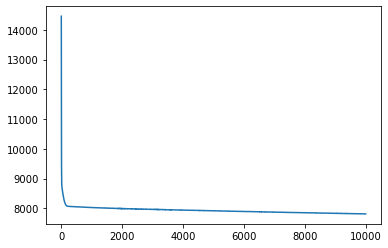

In [449]:
loss = []
for values in history1:
    loss.append(values['val_loss'])
plt.plot(loss)

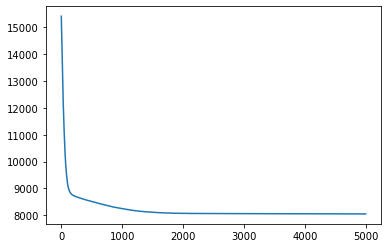

In [450]:
loss = []
for values in history2:
    loss.append(values['val_loss'])
plt.plot(loss)

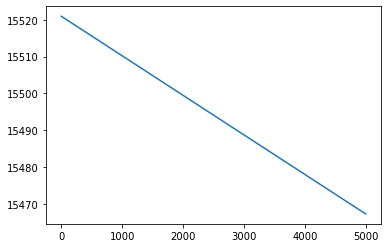

In [451]:
loss = []
for values in history3:
    loss.append(values['val_loss'])
plt.plot(loss)

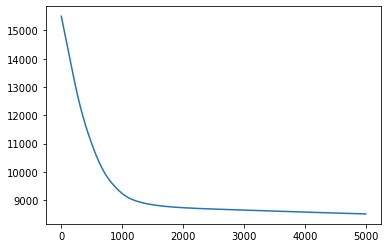

In [452]:
loss = []
for values in history4:
    loss.append(values['val_loss'])
plt.plot(loss)

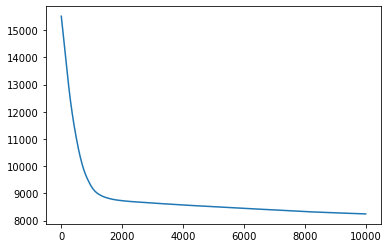

In [453]:
loss = []
for values in history5:
    loss.append(values['val_loss'])
plt.plot(loss)

According to the graph, I chose history2. It looks smoother than any other four graphs. 

In [454]:
model = InsuranceModel()
epochs = 10000
lr = 1e-2
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch [20], val_loss: 13408.4189
Epoch [40], val_loss: 11658.1523
Epoch [60], val_loss: 10461.1826
Epoch [80], val_loss: 9693.0312
Epoch [100], val_loss: 9239.3545
Epoch [120], val_loss: 8995.0479
Epoch [140], val_loss: 8875.6348
Epoch [160], val_loss: 8807.0693
Epoch [180], val_loss: 8761.6318
Epoch [200], val_loss: 8733.0586
Epoch [220], val_loss: 8711.1680
Epoch [240], val_loss: 8693.3643
Epoch [260], val_loss: 8677.7412
Epoch [280], val_loss: 8663.3740
Epoch [300], val_loss: 8648.4346
Epoch [320], val_loss: 8632.9951
Epoch [340], val_loss: 8617.3857
Epoch [360], val_loss: 8603.1211
Epoch [380], val_loss: 8588.9834
Epoch [400], val_loss: 8574.9844
Epoch [420], val_loss: 8562.0332
Epoch [440], val_loss: 8549.6641
Epoch [460], val_loss: 8537.2881
Epoch [480], val_loss: 8525.1211
Epoch [500], val_loss: 8512.8613
Epoch [520], val_loss: 8500.6289
Epoch [540], val_loss: 8488.4219
Epoch [560], val_loss: 8475.9697
Epoch [580], val_loss: 8463.8545
Epoch [600], val_loss: 8451.4893
Epoch [620]

Epoch [4880], val_loss: 8049.5776
Epoch [4900], val_loss: 8049.4785
Epoch [4920], val_loss: 8049.4468
Epoch [4940], val_loss: 8049.3599
Epoch [4960], val_loss: 8049.2383
Epoch [4980], val_loss: 8049.1670
Epoch [5000], val_loss: 8049.0786
Epoch [5020], val_loss: 8048.8965
Epoch [5040], val_loss: 8048.8481
Epoch [5060], val_loss: 8048.8252
Epoch [5080], val_loss: 8048.6528
Epoch [5100], val_loss: 8048.6055
Epoch [5120], val_loss: 8048.4775
Epoch [5140], val_loss: 8048.3325
Epoch [5160], val_loss: 8048.2871
Epoch [5180], val_loss: 8048.2070
Epoch [5200], val_loss: 8048.0767
Epoch [5220], val_loss: 8048.0186
Epoch [5240], val_loss: 8047.9150
Epoch [5260], val_loss: 8047.8066
Epoch [5280], val_loss: 8047.7002
Epoch [5300], val_loss: 8047.5908
Epoch [5320], val_loss: 8047.5371
Epoch [5340], val_loss: 8047.4258
Epoch [5360], val_loss: 8047.3213
Epoch [5380], val_loss: 8047.2690
Epoch [5400], val_loss: 8047.0020
Epoch [5420], val_loss: 8046.9927
Epoch [5440], val_loss: 8046.8442
Epoch [5460], 

Epoch [9700], val_loss: 8025.5405
Epoch [9720], val_loss: 8025.4541
Epoch [9740], val_loss: 8025.3135
Epoch [9760], val_loss: 8025.2651
Epoch [9780], val_loss: 8025.1714
Epoch [9800], val_loss: 8025.0586
Epoch [9820], val_loss: 8024.9585
Epoch [9840], val_loss: 8024.8618
Epoch [9860], val_loss: 8024.7217
Epoch [9880], val_loss: 8024.6553
Epoch [9900], val_loss: 8024.5938
Epoch [9920], val_loss: 8024.4673
Epoch [9940], val_loss: 8024.3711
Epoch [9960], val_loss: 8024.2524
Epoch [9980], val_loss: 8024.1621
Epoch [10000], val_loss: 8024.0420


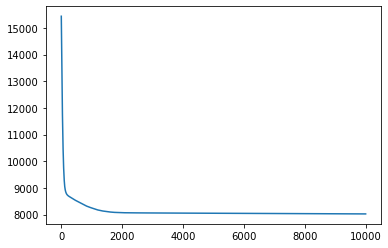

In [455]:
loss = []
for values in history2:
    loss.append(values['val_loss'])
plt.plot(loss)

**Q: What is the final validation loss of your model?**

In [456]:
val_loss = 7927.1519

Let's log the final validation loss to Jovian and commit the notebook

In [457]:
jovian.log_metrics(val_loss=val_loss)

[jovian] Metrics logged.


In [458]:
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression


'https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression'

Now scroll back up, re-initialize the model, and try different set of values for batch size, number of epochs, learning rate etc. Commit each experiment and use the "Compare" and "View Diff" options on Jovian to compare the different results.

## Step 5: Make predictions using the trained model

**Q: Complete the following function definition to make predictions on a single input**



unsqueeze() indicates the position on where to add the dimension. torch.unsqueeze adds an additional dimension to the tensor. So let's say you have a tensor of shape (3), if you add a dimension at the 0 position, it will be of shape (1,3), which means 1 row and 3 columns. If you add at the 1 position, it will be (3,1), which means 3 rows and 1 column. If you have a 2D tensor of shape (2,2) add add an extra dimension at the 0 position, this will result of the tensor having a shape of (1,2,2), which means one channel, 2 rows and 2 columns. If you add at the 1 position, it will be of shape (2,1,2), so it will have 2 channels, 1 row and 2 columns. If you add it at the 2 position, the tensor will be of shape (2,2,1), which means 2 channels, 2 rows and one column.


In [459]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)              # fill this
    prediction = predictions[0].detach()
    print("Input:", input)
    print("Target:", target)
    print("Prediction:", prediction)

In [460]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([58.0000,  0.0000, 36.7410,  0.0000,  0.0000])
Target: tensor([13506.8809])
Prediction: tensor([13566.1650])


In [461]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([33.0000,  0.0000, 47.6634,  3.0000,  0.0000])
Target: tensor([7251.5327])
Prediction: tensor([5828.0620])


In [462]:
input, target = val_ds[23]
predict_single(input, target, model)

Input: tensor([18.0000,  0.0000, 29.6703,  0.0000,  0.0000])
Target: tensor([1841.9740])
Prediction: tensor([2698.4084])


In [463]:
input, target = val_ds[18]
predict_single(input, target, model)

Input: tensor([18.0000,  1.0000, 43.4454,  0.0000,  0.0000])
Target: tensor([14694.6660])
Prediction: tensor([1528.1942])


Are you happy with your model's predictions? Try to improve them further.

## (Optional) Step 6: Try another dataset & blog about it

While this last step is optional for the submission of your assignment, we highly recommend that you do it. Try to clean up & replicate this notebook (or [this one](https://jovian.ml/aakashns/housing-linear-minimal), or [this one](https://jovian.ml/aakashns/mnist-logistic-minimal) ) for a different linear regression or logistic regression problem. This will help solidify your understanding, and give you a chance to differentiate the generic patters in machine learning from problem-specific details.

Here are some sources to find good datasets:

- https://lionbridge.ai/datasets/10-open-datasets-for-linear-regression/
- https://www.kaggle.com/rtatman/datasets-for-regression-analysis
- https://archive.ics.uci.edu/ml/datasets.php?format=&task=reg&att=&area=&numAtt=&numIns=&type=&sort=nameUp&view=table
- https://people.sc.fsu.edu/~jburkardt/datasets/regression/regression.html
- https://archive.ics.uci.edu/ml/datasets/wine+quality
- https://pytorch.org/docs/stable/torchvision/datasets.html

We also recommend that you write a blog about your approach to the problem. Here is a suggested structure for your post (feel free to experiment with it):

- Interesting title & subtitle
- Overview of what the blog covers (which dataset, linear regression or logistic regression, intro to PyTorch)
- Downloading & exploring the data
- Preparing the data for training
- Creating a model using PyTorch
- Training the model to fit the data
- Your thoughts on how to experiment with different hyperparmeters to reduce loss
- Making predictions using the model

As with the previous assignment, you can [embed Juptyer notebook cells & outputs from Jovian](https://medium.com/jovianml/share-and-embed-jupyter-notebooks-online-with-jovian-ml-df709a03064e) into your blog. 

Don't forget to share your work on the forum: https://jovian.ml/forum/t/share-your-work-here-assignment-2/4931

In [ ]:
jovian.commit(project=project_name, environment=None)
jovian.commit(project=project_name, environment=None) # try again, kaggle fails sometimes

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "khinthandarkyaw98/02-insurance-linear-regression" on https://jovian.ml/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ml/khinthandarkyaw98/02-insurance-linear-regression


<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
